In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp
import pickle

from helpers.data import get_pdf_toy_JAX, read_in_data_JAX
from rikabplotlib.plot_utils import newplot
from matplotlib.pyplot import cm



In [2]:
# Plot x-axes labels

x_labels = {"thrust" : r"Thrust $\tau = 1-T$",
            "c_param" : r"C-Parameter $c$",
            "exponential" : r"$x$",
            "rayleigh" : r"$x$"
}

t_labels = {"thrust" : r"$t = \log(1/2\tau)$",
            "c_param" : r"$t = \log(1/c)$",
            "exponential" : r"$t = \log(1/x)$",
            "rayleigh" : r"$t = \log(1/x)$"
}

names = {"thrust" : r"Thrust",
        "c_param" : r"C-Parameter",
        "exponential" : r"Exponential [Toy]",
        "rayleigh" : r"Rayleigh [Toy]"
}


orders = {1 : r"$\mathcal{O}(\alpha_s^1)$",
          2 : r"$\mathcal{O}(\alpha_s^2)$",
          3: r"$\mathcal{O}(\alpha_s^3)$"}

# Colors
colors = ["red", "gold", "green", "blue"][::-1]
darkcolors = ["darkred", "orange", "darkgreen", "darkblue"][::-1]



o1_colors = ["lightsteelblue", "royalblue", "blue", "midnightblue"]
o2_colors = ["thistle", "plum", "violet", "purple"]
o3_colors = ["mistyrose", "lightcoral", "red", "firebrick"]

colors = {1: o1_colors, 2: o2_colors, 3: o3_colors}

In [3]:
# TODO: Replace this with Radha's YAML files
mstar = 1
m = 1
n = 7
dist = "exponential"

mult_factor = 2 if dist == "thrust" else 1

lr = 0.0010
weight_decay = 0.01
epochs = 50000
batch_size = 320*1
seed = 42
freeze_previous_order = False   # NEW
bogo_init = True
random_batch = False

name = f"{dist}_m{m}_n{n}"
init_from = f"{dist}_m{m-1}_n{n}"

# Seed stuff
np.random.seed(seed)
jax_key = jax.random.PRNGKey(seed)


# Initialize params
params = {
    "g_star" : -np.zeros((m+1 - mstar, n+1)),
    "g_coeffs" : -np.zeros((m+1 - mstar, n+1)),
    "thetas" : np.zeros((m+1 - mstar,)),
    "thetas_coeffs" : np.zeros((m+1 - mstar,)),
    "temps" : 5 * np.ones((m+1 - mstar,)),
    "temps_coeffs" : 5 * np.ones((m+1 - mstar,)),
    "temps_positive" : 5 * np.ones((m+1 - mstar,)),
}

beta_limits = [0, 5]


factorials = np.ones_like(params["g_star"])
for mi in range(params["g_star"].shape[0]):
    for ni in range(params["g_star"].shape[1]):
        factorials[mi, ni] = 1 / math.factorial(mi + mstar) / math.factorial(ni)




# # For flavor, slightly smarter inits
signs = (-1) * np.power(-1, np.arange(n + 1) % 2)
params["g_star"][0,1] = -1
params["g_coeffs"][0,1] = -1
params["thetas"][0] = 0.0
if m == 2:
    params["thetas_coeffs"][0] = 0.0
    params["thetas"][1] = 0.0
    params["g_star"][1,2] = 0


# Decent sign initialization
for mi in range(m+1-mstar):
    params["g_star"][mi] *= signs #* factorials[mi]
    params["g_coeffs"][mi] *= signs #* factorials[mi]






No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
from utils.function_utils import polynomial, taylor_expand_in_alpha
from utils.distribution_utils import build_q_mstar
from rikabplotlib.plot_utils import newplot

q = build_q_mstar(mstar)

# compile
q_vmap = jax.vmap(q, in_axes=(0,None,None,None,None,None,None,None,None))


# Taylor Expansions
q0_vmap = jax.vmap(taylor_expand_in_alpha(q, 0), in_axes=(0,None,None,None,None,None,None,None,None,))
q1_vmap = jax.vmap(taylor_expand_in_alpha(q, 1), in_axes=(0,None,None,None,None,None,None,None,None,))
q2_vmap = jax.vmap(taylor_expand_in_alpha(q, 2), in_axes=(0,None,None,None,None,None,None,None,None))
q3_vmap = jax.vmap(taylor_expand_in_alpha(q, 3), in_axes=(0,None,None,None,None,None,None,None,None))
# ... Add more if necessary, can loop if we really have to

qm_vmap = [q0_vmap, q1_vmap, q2_vmap, q3_vmap]

# ##### Second vmap over alpha #####
q_vmap2 = jax.vmap(q_vmap, in_axes = (None, 0, None, None, None, None, None, None, None))
qm_vmap2 = []
for qi in qm_vmap:
    qi_vmap2 = jax.vmap(qi, in_axes = (None, 0, None, None, None, None, None, None,None))
    qm_vmap2.append(qi_vmap2)



# Select the Taylor Expansion Function
CHOSEN_Q_VMAP = qm_vmap[m]
CHOSEN_Q_VMAP2 = qm_vmap2[m]


# Helper functions
def Q_ANSATZ(ts, alphas, params):
    return q_vmap2(ts, alphas, params["g_star"], params["g_coeffs"], params["thetas"], params["thetas_coeffs"], params["temps"], params["temps_coeffs"], params["temps_positive"])

def QM_ANSATZ(ts, alphas, params):
    return CHOSEN_Q_VMAP2(ts, alphas, params["g_star"], params["g_coeffs"], params["thetas"], params["thetas_coeffs"], params["temps"], params["temps_coeffs"], params["temps_positive"])



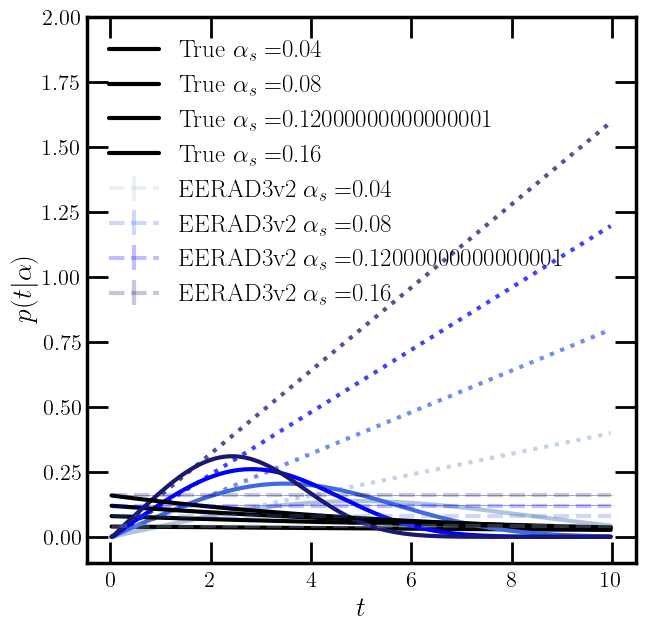

In [5]:
if dist in ["thrust", "c_param"]:
    data_dict, t_bins, t_bin_centers = read_in_data_JAX(dist, m)
    data_true_dict = None
else:
    data_dict = {}
    data_true_dict = {}
    alphas = np.arange(.005, .325, 0.001)
    t_bins = jnp.linspace(0, 10, 201)
    t_bin_centers = (t_bins[1:] + t_bins[:-1])/2

    for a in alphas:
        y_data = get_pdf_toy_JAX(a, dist, t_bin_centers, m)
        y_true_data = get_pdf_toy_JAX(a, dist, t_bin_centers, -1)
        data_dict[a] = np.reshape(y_data, (-1, 1)), np.reshape(0.001 * jnp.ones_like(y_data), (-1, 1))
        data_true_dict[a] = np.reshape(y_true_data, (-1, 1)), np.reshape(0.001 * jnp.ones_like(y_true_data), (-1, 1))


x_bin_centers = jnp.exp(-t_bin_centers)

alpha_keys = np.array(list(data_dict.keys()))
alpha_keys_float = list(data_dict.keys())

t_min = jnp.min(t_bins)
t_max = jnp.max(t_bins)

ALPHA_MAX = 0.2
# alpha_keys_float = alpha_keys_float[alpha_keys <= ALPHA_MAX]
alpha_keys = alpha_keys[alpha_keys <= ALPHA_MAX]

# Keys of interest
keys = np.array([0.04, 0.08, 0.12, 0.16,])

# Find the keys in the list closest to these values (to deal with floating point errors)
for (k, key) in enumerate(keys):

    closest_key = alpha_keys_float[np.argmin(np.abs(key - alpha_keys))]
    keys[k] = closest_key


# Make an array of ys and yerrs so we dont have to keep the dictionary around
ys = []
yerrs = []
for key in alpha_keys:
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]

    # clamp yerr by its nonzero minimum

    min_y_err = np.min(yerr[yerr > 0])
    yerr = np.clip(yerr, a_min=min_y_err.item(), a_max=None)
    
    ys.append(y)
    yerrs.append(yerr)

ys = jnp.array(ys)
yerrs = jnp.array(yerrs)

ys_xs = ys / x_bin_centers
yerrs_xs = yerrs / x_bin_centers


# Make a plot of the data 
fig, ax = newplot("full")
q_vals = Q_ANSATZ(t_bin_centers, keys, params)
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)

for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]


    min_y_err = np.min(yerr[yerr > 0])
    yerr = np.clip(yerr, a_min=min_y_err.item(), a_max=None)

    plt.errorbar(t_bin_centers, y, yerr, color = colors[m][k], ls = "--", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}")
    plt.plot(t_bin_centers, q_vals[k], color = colors[m][k])
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[m][k], alpha = 0.75, ls = "dotted")

    if data_true_dict is not None:
        y_true, _ = data_true_dict[key]
        plt.plot(t_bin_centers, y_true,  color = "black", ls = "-",label = r"True $\alpha_s = $" + f"{key}")


    # plt.plot(t_bin_centers, q_taylor_vals[k] / q_vals[k], color = colors[k], alpha = 0.75, ls = "-.")

plt.ylim(-0.1, 2)
# plt.xscale("log")
plt.xlabel(r"$t$")
plt.ylabel(r"$p(t | \alpha)$")
plt.legend(loc = "upper left")



# Plots



In [6]:

with open(f"output_JAX/{name}_params.pkl", "rb") as f:
    params = pickle.load(f)

with open(f"output_JAX/{name}_params_history.pkl", "rb") as f:
    params_log = pickle.load(f)

with open(f"output_JAX/{name}_loss_history.pkl", "rb") as f:
    losses = pickle.load(f)

In [7]:
import matplotlib as mpl
import matplotlib.patches as mpatches

In [8]:
# Colormap junk

alpha_levels = list(keys)             
alpha_colors = [colors[m][k] for k,_ in enumerate(alpha_levels)] 

alpha2color = {a: c for a, c in zip(alpha_levels, alpha_colors)}


N_colors = len(alpha_levels)
boundaries = np.arange(N_colors+1)  # [0,1,2,...,N]
centers    = np.arange(N_colors) + 0.5
cmap = mpl.colors.ListedColormap(alpha_colors, name="alpha_disc")
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N, clip=True)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array([])

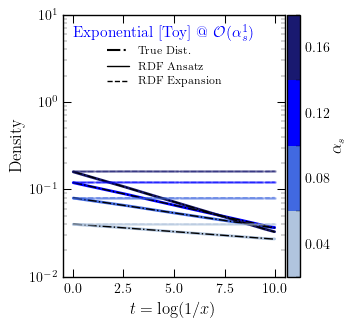

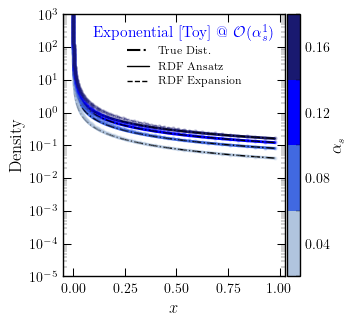

In [9]:
# Make a plot of the data 
fig, ax = newplot("column")
q_vals = Q_ANSATZ(t_bin_centers, keys, params)
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)


# dummy = ax.errorbar([], [], yerr=[], fmt="o", color="grey", ls="none", label="EERAD3v2 data")
legend_handles = [
    mpatches.Patch( facecolor="grey", edgecolor="black", alpha=0.5, label=r"$\texttt{PYTHIA}$ 8.3"),
    ax.errorbar([], [], yerr=[], fmt="o", color="black", ls="none", label=r"$\texttt{EERAD3v2}$ Monte Carlo", elinewidth = 0.75),
    mpl.lines.Line2D([0], [0], color="black", ls="-",  label="RDF Ansatz"),
    mpl.lines.Line2D([0], [0], color="black", ls=":",  label="RDF Expansion"),    
]

# Pythia
if dist == "thrust" or dist == "c_param":
    with open("data/pythia_distribution.pkl", "rb") as f:
        pythia = pickle.load(f)

        if dist == "thrust":

            plt.hist(np.log(1/(2 * pythia["thrusts"])), color = "grey", density="True", alpha = 0.25, bins = 50)
            plt.hist(np.log(1/(2 * pythia["thrusts"])), color = "black", density="True", bins = 50, alpha = 0.75, histtype="step", label = "Pythia 8.3", lw = 1)

        else:
            plt.hist(np.log(1/(1 * np.array(pythia["c_parameters"]))), color = "grey", density="True", alpha = 0.25, bins = 50)
            plt.hist(np.log(1/(1 * np.array(pythia["c_parameters"]))), color = "black", density="True", bins = 50, alpha = 0.75, histtype="step", label = "Pythia 8.3", lw = 1)



for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]
    min_y_err = np.min(yerr[yerr > 0])
    plt.errorbar(t_bin_centers, y, yerr, color = colors[m][k], fmt = "o", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}", elinewidth = 0.25, ms = 1)
    plt.plot(t_bin_centers, q_taylor_vals[k], color = colors[m][k], alpha = 0.5, ls = "--")
    plt.plot(t_bin_centers, q_vals[k], color = colors[m][k], lw = 2)


if dist == "exponential" or dist == "rayleigh":
    for (k, key) in enumerate(keys):
        y_true, _ = data_true_dict[key]
        plt.plot(t_bin_centers, y_true,  color = "black", ls = "dashdot",label = r"True $\alpha_s = $" + f"{key}", lw = 1.0)

        legend_handles = [
            mpl.lines.Line2D([0], [0], color="black", ls="dashdot",  label="True Dist.", lw = 1.5),
            mpl.lines.Line2D([0], [0], color="black", ls="-",  label="RDF Ansatz"),
            mpl.lines.Line2D([0], [0], color="black", ls="--",  label="RDF Expansion"),    
        ]        

# plt.xscale("log")
plt.xlabel(t_labels[dist])
plt.ylabel(r"Density")


cbar = plt.colorbar(mappable, ax=ax, boundaries=boundaries, ticks=centers, pad=0.01)
cbar.ax.tick_params(size = 0)
cbar.set_ticklabels([f"{a : .2f}" for a in alpha_levels])
cbar.set_label(r"$\alpha_s$", labelpad = 0.01)

plt.yscale("log")
plt.ylim(0.01, 1e1)
ax.legend(handles=legend_handles, loc="upper left", title = names[dist] + " @ " + orders[m], fontsize = 8)
ax.get_legend().get_title().set_color(colors[m][2])


plt.savefig(f"figures/{dist}_{m}_t.pdf", bbox_inches = "tight")




# x-version

# Make a plot of the data 
fig, ax = newplot("column")
x_bin_centers = np.exp(-t_bin_centers) 
q_vals = Q_ANSATZ(t_bin_centers, keys, params)
q_taylor_vals = QM_ANSATZ(t_bin_centers, keys, params)



# dummy = ax.errorbar([], [], yerr=[], fmt="o", color="grey", ls="none", label="EERAD3v2 data")
legend_handles = [
    mpatches.Patch( facecolor="grey", edgecolor="black", alpha=0.5, label=r"$\texttt{PYTHIA}$ 8.3"),
    ax.errorbar([], [], yerr=[], fmt="o", color="black", ls="none", label=r"$\texttt{EERAD3v2}$ Monte Carlo", elinewidth = 0.75),
    mpl.lines.Line2D([0], [0], color="black", ls="-",  label="RDF Ansatz"),
    mpl.lines.Line2D([0], [0], color="black", ls="--",  label="RDF Expansion"),    
]



# Pythia
if dist == "thrust" or dist == "c_param":
    with open("data/pythia_distribution.pkl", "rb") as f:
        pythia = pickle.load(f)

        if dist == "thrust":

            plt.hist(((1 * pythia["thrusts"])), color = "grey", density="True", alpha = 0.25, bins = 50)
            plt.hist(((1 * pythia["thrusts"])), color = "black", density="True", bins = 50, alpha = 0.75, histtype="step", label = "Pythia 8.3", lw = 2)

        else:
            plt.hist(((1 * pythia["c_parameters"])), color = "grey", density="True", alpha = 0.25, bins = 50)
            plt.hist(((1 * pythia["c_parameters"])), color = "black", density="True", bins = 50, alpha = 0.75, histtype="step", label = "Pythia 8.3", lw = 2)


for (k, key) in enumerate(keys):
    y, yerr = data_dict[key]
    y = y[:,0]
    yerr = yerr[:,0]

    min_y_err = np.min(yerr[yerr > 0])
    plt.errorbar(x_bin_centers / mult_factor, y/ x_bin_centers * mult_factor, yerr / x_bin_centers * mult_factor, color = colors[m][k], fmt = "o", alpha = 0.25 ,label = r"EERAD3v2 $\alpha_s = $" + f"{key}", elinewidth = 0.75, ms = 2)
    plt.plot(x_bin_centers / mult_factor, q_taylor_vals[k] / x_bin_centers * mult_factor, color = colors[m][k], alpha = 0.5, ls = "--")
    plt.plot(x_bin_centers / mult_factor, q_vals[k] / x_bin_centers * mult_factor, color = colors[m][k], lw = 2)


if dist == "exponential" or dist == "rayleigh":
    for (k, key) in enumerate(keys):
        y_true, _ = data_true_dict[key]
        plt.plot(x_bin_centers / mult_factor, y_true[:,0] / x_bin_centers * mult_factor,  color = "black", ls = "dashdot",label = r"True $\alpha_s = $" + f"{key}", lw = 1.0)

        legend_handles = [
            mpl.lines.Line2D([0], [0], color="black", ls="dashdot",  label="True Dist.", lw = 1.5),
            mpl.lines.Line2D([0], [0], color="black", ls="-",  label="RDF Ansatz"),
            mpl.lines.Line2D([0], [0], color="black", ls="--",  label="RDF Expansion"),    
        ]


if dist == "thrust":
    plt.xlim(0, 0.5)


# plt.xlim(0, 0.5)
plt.yscale("log")
plt.ylim(1e-5, 1e3)
# plt.xscale("log")
plt.xlabel(x_labels[dist])
plt.ylabel(r"Density")

ax.legend(handles=legend_handles, loc="upper right", title = names[dist] + " @ " + orders[m], fontsize = 8)
ax.get_legend().get_title().set_color(colors[m][2])

cbar = plt.colorbar(mappable, ax=ax, boundaries=boundaries, ticks=centers, pad=0.01)
cbar.ax.tick_params(size = 0)
cbar.set_ticklabels([f"{a : .2f}" for a in alpha_levels])
cbar.set_label(r"$\alpha_s$", labelpad = 0.01)

plt.savefig(f"figures/{dist}_{m}_x.pdf", bbox_inches = "tight")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


RuntimeError: latex was not able to process the following string:
b'$T%{\\\\rm Abs.}_1$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpwqzrdjeq 98e02706a575eef76f679a4a085065b5.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./98e02706a575eef76f679a4a085065b5.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 98e02706a575eef76f679a4a085065b5.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.31 \end{document}
                   
No pages of output.
Transcript written on tmpwqzrdjeq/98e02706a575eef76f679a4a085065b5.log.




Error in callback <function _draw_all_if_interactive at 0x785d666d4dc0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'$T%{\\\\rm Abs.}_1$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmppg3xrla7 98e02706a575eef76f679a4a085065b5.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./98e02706a575eef76f679a4a085065b5.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 98e02706a575eef76f679a4a085065b5.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.31 \end{document}
                   
No pages of output.
Transcript written on tmppg3xrla7/98e02706a575eef76f679a4a085065b5.log.




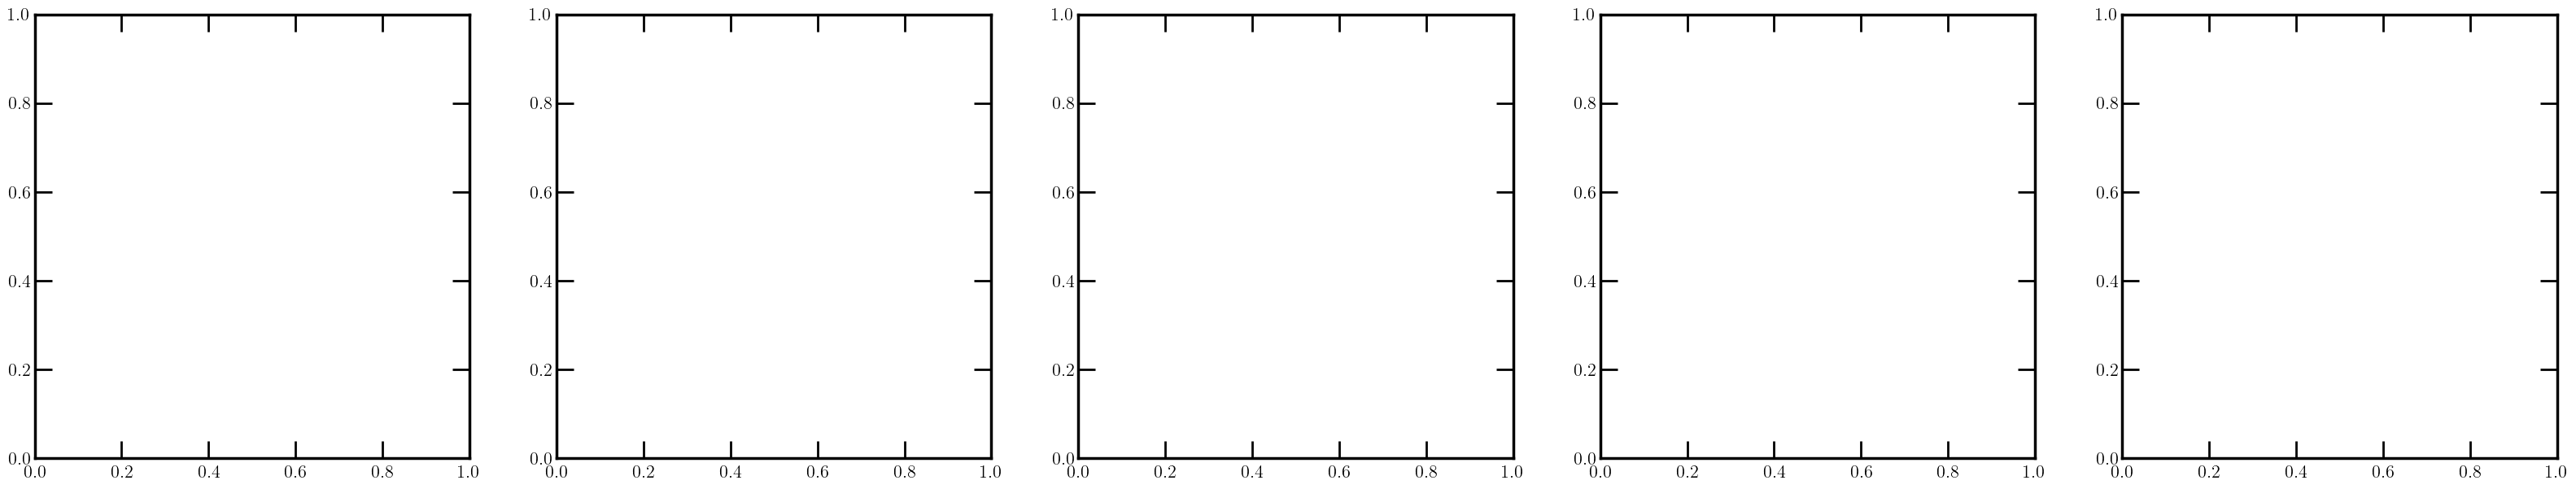

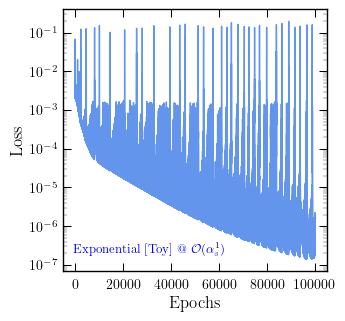

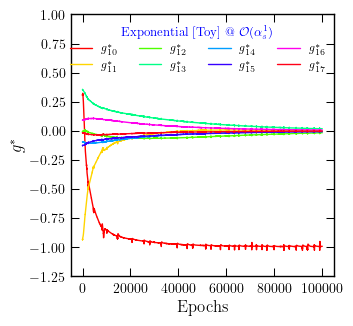

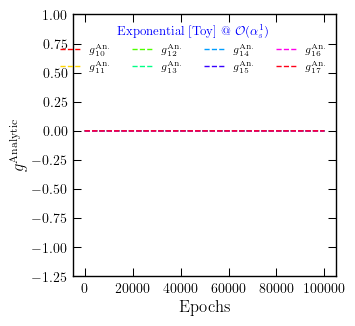

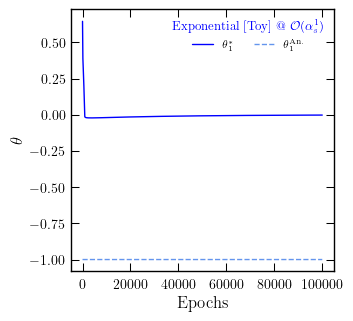

RuntimeError: latex was not able to process the following string:
b'$T%{\\\\rm Abs.}_1$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmpl79iw54a 98e02706a575eef76f679a4a085065b5.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./98e02706a575eef76f679a4a085065b5.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 98e02706a575eef76f679a4a085065b5.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.31 \end{document}
                   
No pages of output.
Transcript written on tmpl79iw54a/98e02706a575eef76f679a4a085065b5.log.




<Figure size 340.278x340.278 with 1 Axes>

In [26]:

fig, ax = newplot("full", width = 8 * 5, subplot_array=(1, 5))

losses = np.array(losses)
g_star_log = np.array([b["g_star"] for b in params_log])
g_coeffs_log = np.array([b["g_coeffs"] for b in params_log])
thetas_log = np.array([b["thetas"] for b in params_log])
temps_log = np.array([b["temps"] for b in params_log])
thetas_c_log = np.array([b["thetas_coeffs"] for b in params_log])
temps_c_log = np.array([b["temps_coeffs"] for b in params_log])
temps_p_log = np.array([b["temps_positive"] for b in params_log])


color = iter(
    cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2]))
)


# ##### Loss #####

fig, ax = newplot("column")

plt.plot(losses, color = "cornflowerblue")
plt.yscale("log")
ax.legend(loc="lower left", title = names[dist] + " @ " + orders[m], fontsize = 8, title_fontsize = 9)
ax.get_legend().get_title().set_color(colors[m][2])

plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.savefig("figures/appendix_loss.pdf", bbox_inches = "tight")


# ##### gstar #####

fig, ax = newplot("column")

color = iter(
    cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2]))
)

for mi in range(g_star_log.shape[1]):



    for ni in range(g_star_log.shape[2]):

        c = next(color)
        plt.plot(g_star_log[:,mi,ni], color = c, label = r"$g^*_{" + f"{mi+1}{ni}" + r"}$")

ax.legend(loc="upper right", title = names[dist] + " @ " + orders[m], fontsize = 8, title_fontsize = 9, ncol = 4)
ax.get_legend().get_title().set_color(colors[m][2])
ax.set_ylabel(r"$g^*$")
ax.set_xlabel("Epochs")

plt.ylim(-1.25, 1.0)


plt.savefig("figures/appendix_gstar.pdf", bbox_inches = "tight")


# ##### g_analytic #####

fig, ax = newplot("column")

color = iter(
    cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2]))
)

for mi in range(g_star_log.shape[1]):



    for ni in range(g_star_log.shape[2]):

        c = next(color)
        plt.plot(g_coeffs_log[:,mi,ni], color = c, label = r"$g^{\rm An.}_{" + f"{mi+1}{ni}" + r"}$", ls = "--")

ax.legend(loc="upper right", title = names[dist] + " @ " + orders[m], fontsize = 7.5, title_fontsize = 9, ncol = 4)
ax.get_legend().get_title().set_color(colors[m][2])
ax.set_ylabel(r"$g^{\rm Analytic}$")
ax.set_xlabel("Epochs")

plt.ylim(-1.25, 1.0)


plt.savefig("figures/appendix_ganalytic.pdf", bbox_inches = "tight")


# ##### theta #####

fig, ax = newplot("column")

color = iter(
    cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2]))
)



for mi in range(g_star_log.shape[1]):

   
    ax.plot(thetas_log[:,mi], label = r"$\theta^{*}_" + f"{mi+1}" + r"$", color = "blue")
    ax.plot(thetas_c_log[:,mi], label = r"$\theta^{\rm An.}_" + f"{mi+1}" + r"$", color = "cornflowerblue", ls = "--")


ax.legend(loc="upper right", title = names[dist] + " @ " + orders[m], fontsize = 7.5, title_fontsize = 9, ncol = 3)
ax.get_legend().get_title().set_color(colors[m][2])
ax.set_ylabel(r"$\theta$")
ax.set_xlabel("Epochs")

plt.savefig("figures/appendix_theta.pdf", bbox_inches = "tight")


# ##### temp #####

fig, ax = newplot("column")

color = iter(
    cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1] * g_coeffs_log.shape[2]))
)



for mi in range(g_star_log.shape[1]):

   
    ax.plot(temps_log[:,mi], label = r"$T^{*}_" + f"{mi+1}" + r"$", color = "blue")
    ax.plot(temps_c_log[:,mi], label = r"$T^{\rm An.}_" + f"{mi+1}" + r"$", color = "cornflowerblue", ls = "--")
    ax.plot(temps_p_log[:,mi], label = r"$T%{\rm Abs.}_" + f"{mi+1}" + r"$", color = "darkblue", ls = "dotted")


ax.legend(loc="lower right", title = names[dist] + " @ " + orders[m], fontsize = 7.5, title_fontsize = 9, ncol = 4)
ax.get_legend().get_title().set_color(colors[m][2])
ax.set_ylabel(r"$T / 100$")
ax.set_xlabel("Epochs")
plt.yscale("log")


plt.savefig("figures/appendix_temp.pdf", bbox_inches = "tight")





# ax[0].plot(losses)
# ax[0].set_yscale("log")

# for mi in range(g_star_log.shape[1]):



#     for ni in range(g_star_log.shape[2]):

#         c = next(color)

#         ax[1].plot(g_star_log[:,mi,ni], color = c, label = f"g_star_{mi}{ni}")
#         ax[2].plot(g_coeffs_log[:,mi,ni], color = c, label = f"g_coeffs_{mi}{ni}")


#     ax[3].plot(thetas_log[:,mi], label = f"theta_{mi}", color = c)
#     ax[4].plot(temps_log[:,mi], label = f"beta_{mi}", color = c)

#     ax[3].plot(thetas_c_log[:,mi], label = f"theta_coeffs_{mi}", color = c, ls = "--")
#     ax[4].plot(temps_c_log[:,mi], label = f"beta_coeffs_{mi}", color = c, ls = "--")

# ax[0].set_ylabel("loss")
# ax[0].set_xlabel("epochs")

# ax[1].legend()
# ax[1].set_ylabel("g_star")
# ax[1].set_xlabel("epochs")

# ax[2].legend()
# ax[2].set_ylabel("g_coeffs")
# ax[2].set_xlabel("epochs")

# ax[3].legend()
# ax[3].set_ylabel("theta")
# ax[3].set_xlabel("epochs")


# ax[4].legend()
# ax[4].set_ylabel("beta")
# ax[4].set_xlabel("epochs")


In [11]:
from utils.function_utils import polynomial
from utils.distribution_utils import q, log_q, f
from rikabplotlib.plot_utils import newplot

# compile
q_vmap = q
f_vmap = jax.vmap(f, in_axes=(0,None,None,None, None))
polynomial_vmap = jax.vmap(polynomial, in_axes=(0,None,None,None))
# TODO: automate vmap compilation


ts = jnp.linspace(0, 10, 500)
alpha = 0.118

# Hardcode correct answer
g_star = -jnp.array([[0, 0, 0,],
                [1, 0, 0,],
                [0, 1, 0]]) # My stupid convention has a minus in front of gstar

g_mn = jnp.zeros_like(g_star)

thetas = jnp.array([0, 0.5, 0.25])


q_vals = q_vmap(ts, alpha, g_star, g_mn, thetas)
f_vals = f_vmap(ts, alpha, g_star, g_mn, thetas)
poly_vals = polynomial_vmap(ts, alpha, g_star, thetas)

# Verify integral of q_vals
print(jnp.trapz(q_vals,ts))

fig, ax = newplot("full")
plt.plot(ts, q_vals, color = "blue", label = "JAX RDF")
plt.plot(ts, f_vals, color = "lightblue", label = "Target", ls = "--")

print(jnp.trapz(f_vals, ts))

# 
# plt.xscale("log")
# 

ImportError: cannot import name 'log_q' from 'utils.distribution_utils' (/home/rikab/Documents/Research/NNEFT/numeric/utils/distribution_utils.py)

In [ ]:
plt.plot(ts, jax.nn.softplus(10*ts)/ 10)
plt.plot(ts, ts * (ts > 0))

In [ ]:
from utils.function_utils import taylor_expand_in_alpha




q0 = jax.vmap(taylor_expand_in_alpha(q, 0), in_axes=(0,None,None,None,None))
q1 = jax.vmap(taylor_expand_in_alpha(q, 1), in_axes=(0,None,None,None,None))
q2 = jax.vmap(taylor_expand_in_alpha(q, 2), in_axes=(0,None,None,None,None))

ts = jnp.linspace(0, 10, 500)

fig, ax = newplot("full")
plt.plot(ts, q_vals, color = "red", label = "JAX RDF")

q1_vals = q1(ts, alpha, g_star, g_mn, thetas)
q2_vals = q2(ts, alpha, g_star, g_mn, thetas)

# plt.plot(ts, q1_vals)
plt.plot(ts, q2_vals, color = "black", label = "Target")
plt.plot(ts, q2_vals, color = "red", label = "RDF O(2)", ls = "--")

plt.ylim(-0.1, 0.25)
plt.xlabel("t")
plt.ylabel('p')
plt.xscale("log")
plt.legend()
# plt.plot(ts, q2_vals - f_vals)




In [ ]:
try:
    plt.style.use('/global/cfs/cdirs/m3246/rikab/dimuonAD/helpers/style_full_notex.mplstyle')
except:
    pass
device = "cpu"

In [ ]:

outfile_name = f"thrust_1_3d"

save_dict = {}

with open(f"output/{outfile_name}_config", "rb") as ifile:
    save_dict["configs"] = pickle.load(ifile)
   
losses = np.load(f"output/{outfile_name}_losses.npy")
g_coeffs_log = np.load(f"output/{outfile_name}_g_coeffs.npy")
theta_log = np.load(f"output/{outfile_name}_theta.npy")


distribution = save_dict["configs"]["distribution"]
order_to_match = save_dict["configs"]["order_to_match"]
name = save_dict["configs"]["name"]
mstar = save_dict["configs"]["mstar"]
run_toy = save_dict["configs"]["run_toy"]

print(save_dict["configs"])

In [ ]:
# Helper functions ofr plotting

max_M, max_N = g_coeffs_log[0].shape


factorial_cache_n = jnp.array([math.factorial(k) for k in range(max_N)], dtype=jnp.float32)
factorial_cache_m = jnp.array([math.factorial(k) for k in range(max_M)], dtype=jnp.float32)
n_range = jnp.arange(max_N, dtype=jnp.int32)
m_range = jnp.arange(1, max_M, dtype=jnp.int32)

factorial_cache_info = factorial_cache_m, factorial_cache_n, m_range, n_range



In [ ]:


# Plot loss
plt.figure()
plt.plot(losses, label="MSE loss")
plt.legend()
plt.yscale("log")
plt.xlabel("Epoch")
plt.show()



In [ ]:


from matplotlib.pyplot import cm
color = iter(cm.hsv(np.linspace(0, 1, g_coeffs_log.shape[1]*g_coeffs_log.shape[2])))

plt.figure()
for m in range(g_coeffs_log.shape[1]):
    for n in range(g_coeffs_log.shape[2]):
        c = next(color)
        label = f"$g_{{{m}{n}}}$"
        plt.plot(g_coeffs_log[:, m, n], label=label, color=c)
plt.legend(loc = (0, 1), ncol = 3)
plt.xlabel("Epoch")
plt.ylabel("Coefficient value")
plt.savefig(f"figures/{outfile_name}_coeffs_nice.png", bbox_inches = "tight")

plt.show()



In [ ]:



if save_dict["configs"]["use_logbins"]:
    t_bins = jnp.logspace(
        np.log10(save_dict["configs"]["t_min"]), np.log10(save_dict["configs"]["t_max"]), save_dict["configs"]["n_bins"]
    )
    t_bin_centers = jnp.sqrt((t_bins[1:] * t_bins[:-1]))
else:
    t_bins = jnp.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], save_dict["configs"]["n_bins"])
    t_bin_centers = 0.5 * (t_bins[1:] + t_bins[:-1])
   

if not run_toy:  # only needs to be done once
    data_dict,t_bins,t_bin_centers = read_in_data_JAX(distribution, order_to_match)
t_min = jnp.min(t_bins)
t_max = jnp.max(t_bins)

tt = jnp.linspace(save_dict["configs"]["t_min"], save_dict["configs"]["t_max"], 200)

colors = ["red", "purple", "blue"]


## Plot Taylor expansion